# imports

In [ ]:
# Download Dataset from kaggle 
# using kaggle api download DR dataset

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install pybboxes
import shutil
import os 
import pandas as pd
# import pybboxes as pbx


In [ ]:
path = '/content/drive/MyDrive'
dataset_path = os.path.join(path,'dataset_of_presentation_scoring')
labels_path = os.path.join(path,'labels')
print(path,dataset_path,labels_path)

/content/drive/MyDrive /content/drive/MyDrive/dataset_of_presentation_scoring /content/drive/MyDrive/labels


In [ ]:
code = ['Delight','Confusion','Frustration','Boredom']
integer_mapping = {x: i for i,x in enumerate(code)}


# Helper functions

In [ ]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

In [ ]:
def sorter(arr):
  arr.sort()
  return arr

In [ ]:
import os
def paths_to_dict(folder:str):
  full_path = f'{path}/{folder}'
  folders = os.listdir(full_path)
  dataset_paths = {}
  for folder in folders:
  
    dataset_paths[folder] = os.listdir(os.path.join(full_path,folder))

  return dataset_paths

In [ ]:
def vid_to_img(vid_key,vid_name):
  cap= cv2.VideoCapture(os.path.join(dataset_path,vid_key,vid_name))
  
  frameNr = 0
  imgs=[]
  count = 0
  captions=[]
  while cap.isOpened():
  
      success, frame = cap.read()
  
      if success:
          # cv2.imwrite(f'C:/Users/N/Desktop/output/frame_{frameNr}.jpg', frame)

          count += 15 
          cap.set(cv2.CAP_PROP_POS_FRAMES, count)
          img1 = frame.copy()
          img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
          imgs.append(img1)
          captions.append(count)

      else:
          cap.release()
          break
  return imgs



In [ ]:
imgs = vid_to_img('Presenter No1-Asylah','C_Presenter No1-GroupD-part1.mp4')

In [ ]:
# len(imgs)

In [ ]:
def clean_df_imgs(df_key,df_name,imgs):
  df = pd.read_csv(os.path.join(labels_path,df_key,df_name))
  useless_df = df[df['label'].map(len) == 8]
  useless_array = useless_df['set_fram'].to_numpy()
  df = df.drop(useless_array)
  for index in sorted(useless_array, reverse=True):
    del imgs[index]
  return df,imgs

In [ ]:
df,imgs = clean_df_imgs('Presenter No1-Asylah','C_Presenter No1-GroupD-part1.csv',imgs)

In [ ]:
# len(df),len(imgs)

#creating paths dicts

In [ ]:
all_images = []
all_dfs = []

In [ ]:
dataset_paths = paths_to_dict('dataset_of_presentation_scoring')
labels_paths = paths_to_dict('labels')

dataset_paths['Presenter No1-Asylah'].remove('.ipynb_checkpoints')

In [ ]:
for key,values in dataset_paths.items():

  print(key)
  for value in values:
    imgs = vid_to_img(key,value)
    size = len(value)
    value = value.replace(value[size-3:],'csv')
    df,imgs = clean_df_imgs(key,value,imgs)
    all_images.append(imgs)
    all_dfs.append(df)
  



Presenter No1-Asylah
Presenter No10-Rana
Presenter No11-Rafeef
Presenter No12-Aqail
Presenter No13-Nurin
Presenter No14-Ikhwan
Presenter No15-Fareena
Presenter No16-Shasha
Presenter No17-Arif
Presenter No18- Shabab
Presenter No19-Eileen-Tong
Presenter No2-Danial
Presenter No20-Syarifah
Presenter No21-Gaith
Presenter No22-Ossamah
Presenter No3-Afyfah
Presenter No4-Muhtasim
Presenter No5-Pavel
Presenter No6-Majid
Presenter No7-Norizal
Presenter No8-Aber
Presenter No9-Anis


In [ ]:
all_dfs[59]=all_dfs[59][:len(all_images[59])]
all_images[70]=all_images[70][:len(all_dfs[70])]
all_dfs[83]=all_dfs[83][:len(all_images[83])]

In [ ]:
for i in range(len(all_dfs)):
  assert(len(all_dfs[i])==len(all_images[i]))

In [ ]:
import h5py
import os

In [ ]:
class HDF5DatasetWriter:
  def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
    # check to see if the output path exists, and if so, raise
    # an exception
    # if os.path.exists(outputPath):
    #   raise ValueError("The supplied ‘outputPath‘ already "
    #   "exists and cannot be overwritten. Manually delete "
    #   "the file before continuing.", outputPath)

    # open the HDF5 database for writing and create two datasets:
    # one to store the images/features and another to store the
    # class labels
    self.db = h5py.File(outputPath, "w")
    self.data = self.db.create_dataset(dataKey, dims,
    dtype="float")
    self.labels = self.db.create_dataset("labels", (dims[0],),
    dtype="int")

    # store the buffer size, then initialize the buffer itself
    # along with the index into the datasets
    self.bufSize = bufSize
    self.buffer = {"data": [], "labels": []}
    self.idx = 0

  def add(self, rows, labels):
      # add the rows and labels to the buffer
      self.buffer["data"].extend(rows)
      self.buffer["labels"].extend(labels)
      # check to see if the buffer needs to be flushed to disk
      if len(self.buffer["data"]) >= self.bufSize:
        self.flush()

  def flush(self):
      # write the buffers to disk then reset the buffer
      i = self.idx + len(self.buffer["data"])
      self.data[self.idx:i] = self.buffer["data"]
      self.labels[self.idx:i] = self.buffer["labels"]
      self.idx = i
      self.buffer = {"data": [], "labels": []}

  def close(self):
      # check to see if there are any other entries in the buffer
      # that need to be flushed to disk
      if len(self.buffer["data"]) > 0:
        self.flush()

      # close the dataset
      self.db.close()

In [ ]:
sum = 0
for i in all_images:
  sum+=len(i)

In [ ]:
sum

18146

In [ ]:
# with h5py.File('dataset_presentation.hdf5', 'w') as hf:
#     dset_x_train = hf.create_dataset('all_image',data = [item for sublist in all_images for item in sublist],shape=(sum, 720, 1280, 1), compression='gzip', chunks=True) 

In [ ]:

# dataset = HDF5DatasetWriter((sum, 1280),'/content/dataset2.hdf5')


In [ ]:
# for i in range(len(all_images)):
#   for j in range(len(all_images[i])):
#     print(i+j)
#     dataset.add(all_images[i][j],integer_mapping[full_dataframe.iloc[[i+j]].squeeze()['label']])


In [ ]:
# integer_mapping[full_dataframe.iloc[[i+j]].squeeze()['label']]

In [ ]:
full_dataframe = pd.DataFrame

In [ ]:
full_images = [item for sublist in all_images for item in sublist]

In [ ]:
import gc
gc.collect()

198

In [ ]:
for i in range(len(all_dfs)):
  if i ==0:
    full_dataframe = all_dfs[i]
  else:
    full_dataframe = full_dataframe.append(all_dfs[i], ignore_index = True)

In [ ]:
 full_dataframe['label'].unique()

array(['Frustration', 'Delight', 'Boredom', 'Confusion', 'Engaged'],
      dtype=object)

In [ ]:
import typing
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> typing.Union[None, typing.Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

In [ ]:
del all_dfs

#Media_Pipe

In [ ]:
!pip install mediapipe

In [ ]:
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection

help(mp_face_detection.FaceDetection)

In [ ]:
# Prepare DrawingSpec for drawing the face landmarks later.
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

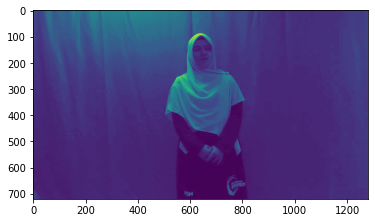

In [ ]:
plt.imshow(full_images[0])

xmin: 0.5094407200813293
ymin: 0.09208694100379944
width: 0.07119196653366089
height: 0.12659195065498352

xmin: 0.5053090453147888
ymin: 0.09213823080062866
width: 0.0827016830444336
height: 0.14702743291854858



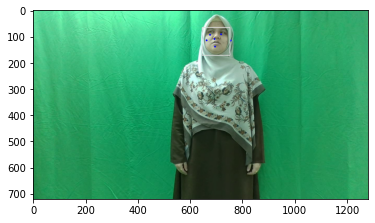

In [ ]:
with mp_face_detection.FaceDetection(
    min_detection_confidence=0.5, model_selection=1) as face_detection:
  for image in imgs[:2]:
    # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face detections of each face.
    if not results.detections:
      print('gay')
      continue
    annotated_image = image.copy()
    for detection in results.detections:
      print(detection.location_data.relative_bounding_box)
      mp_drawing.draw_detection(annotated_image, detection)
    plt.imshow(annotated_image)

#Custom Data Generation

In [ ]:

code = full_dataframe['label'].unique()
integer_mapping = {x: i for i,x in enumerate(code)}

In [ ]:
from skimage.feature import hog
from skimage import exposure


fd, hog_image = hog(imgs[1], orientations=10, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)


(720, 1280, 3)


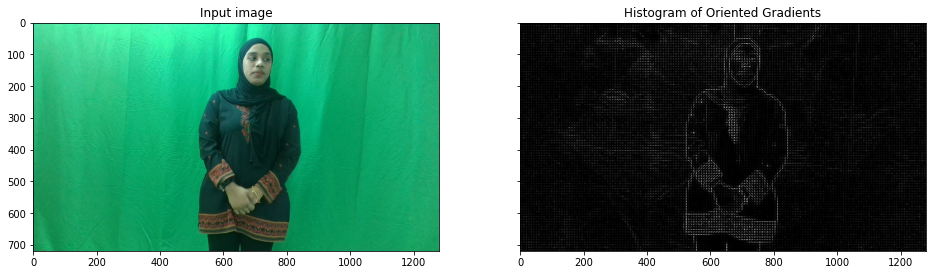

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(imgs[1], cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 20)) 
hog_image_rescaled = cv2.merge([hog_image_rescaled,hog_image_rescaled,hog_image_rescaled])
print(hog_image_rescaled.shape)

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
len(h)

43375500

In [ ]:
from PIL import Image


In [ ]:
import tensorflow as tf
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, imgs,df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=False):
        self.imgs = imgs
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_label = df[y_col['label']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self,img,Xbbox,Ybbox,Wbbox,Hbbox,target_size):
        xmin, ymin, w, h = Xbbox,Ybbox,Wbbox,Hbbox
        yolo_bbox1 = (xmin,ymin,w,h)
        W, H = 1280, 720
        rect_start_point = _normalized_to_pixel_coordinates(
        xmin, ymin, W,H)

        rect_end_point = _normalized_to_pixel_coordinates(
        xmin + w,
        ymin + h, W, H)  
        image_arr = tf.keras.preprocessing.image.img_to_array(img)
        if not(rect_start_point is None or rect_end_point is None):
        
          image_arr = image_arr[rect_start_point[1]:rect_end_point[1],rect_start_point[0]:rect_end_point[0],]

        image_arr = tf.image.resize(image_arr,(target_size[0],target_size[1])).numpy()
        image_arr = image_arr.astype(np.uint8)
        image_arr = Image.fromarray(image_arr)
        fd, hog_image = hog(image_arr, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 
        hog_image_rescaled = cv2.merge([hog_image_rescaled,hog_image_rescaled,hog_image_rescaled])

        # hog_image_rescaled.shape 
        return hog_image_rescaled
    
    def __get_output(self, label, num_classes):
        label = integer_mapping[label]
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, imgs,batches):
        # Generates data containing batch_size samples

        imgs_batch = imgs
        
        label_batch = batches[self.y_col['label']]
        Xbbox_batch = batches[self.X_col['x']]
        Ybbox_batch = batches[self.X_col['y']]
        Wbbox_batch = batches[self.X_col['w']]
        Hbbox_batch = batches[self.X_col['h']]

        X_batch = np.asarray([self.__get_input(img,Xbbox,Ybbox,Wbbox,Hbbox,self.input_size) for img,Xbbox,Ybbox,Wbbox,Hbbox in zip(imgs_batch,Xbbox_batch,Ybbox_batch,Wbbox_batch,Hbbox_batch)])
        y_batch = np.asarray([self.__get_output(y, self.n_label) for y in label_batch])

        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        imgs_batches = self.imgs[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(imgs_batches,batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
interval = int(len(full_dataframe)*0.8)
traingen = CustomDataGen(df = full_dataframe[:interval],
                         imgs = full_images[:interval],
                         X_col={'x':'x', 'y': 'y','w':'w', 'h': 'h'},
                         y_col={'label': 'label'},
                         batch_size=8)

valgen = CustomDataGen(df = full_dataframe[interval:],
                         imgs = full_images[interval:],
                         X_col={'x':'x', 'y': 'y','w':'w', 'h': 'h'},
                         y_col={'label': 'label'},
                         batch_size=8)




In [ ]:
STEP_SIZE_TRAIN = traingen.n // traingen.batch_size
STEP_SIZE_VALID = valgen.n // valgen.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

1814
453


In [ ]:
traingen

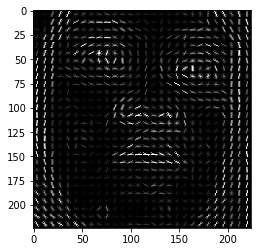

In [ ]:
plt.imshow(traingen[1][0][7],"PuRd")

In [ ]:
np.max(traingen[0][0][2])

0.01053572784003336

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [ ]:
base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=5 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)

In [ ]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]
hist = model.fit_generator(traingen, 
                           steps_per_epoch= STEP_SIZE_TRAIN,
                           epochs= 30, 
                           validation_data= valgen, 
                           validation_steps= STEP_SIZE_VALID, 
                           callbacks=call_back,
                           verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
1814/1814 [==============================] - ETA: 0s - loss: 11.6876 - accuracy: 0.5203
Epoch 1: val_accuracy improved from -inf to 0.47103, saving model to best_model.h5
1814/1814 [==============================] - 2571s 1s/step - loss: 11.6876 - accuracy: 0.5203 - val_loss: 14.7159 - val_accuracy: 0.4710
Epoch 2/30
1814/1814 [==============================] - ETA: 0s - loss: 9.3239 - accuracy: 0.6366
Epoch 2: val_accuracy did not improve from 0.47103
1814/1814 [==============================] - 2546s 1s/step - loss: 9.3239 - accuracy: 0.6366 - val_loss: 29.2903 - val_accuracy: 0.2922
Epoch 3/30
1814/1814 [==============================] - ETA: 0s - loss: 8.2650 - accuracy: 0.6871
Epoch 3: val_accuracy did not improve from 0.47103
1814/1814 [==============================] - 2544s 1s/step - loss: 8.2650 - accuracy: 0.6871 - val_loss: 16.3285 - val_accuracy: 0.4324
Epoch 4/30
1814/1814 [==============================] - ETA: 0s - loss: 6.5973 - accuracy: 0.7251
Epoch 4: val_